In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1. load Data

In [3]:
#load data
data = pd.read_csv("data/fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv("data/fold_1_data.txt",sep = "\t")
data2 = pd.read_csv("data/fold_2_data.txt",sep = "\t")
data3 = pd.read_csv("data/fold_3_data.txt",sep = "\t")
data4 = pd.read_csv("data/fold_4_data.txt",sep = "\t")

In [4]:
total_data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)
print(total_data.shape) # should be 19370, 12

(19370, 12)


In [5]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


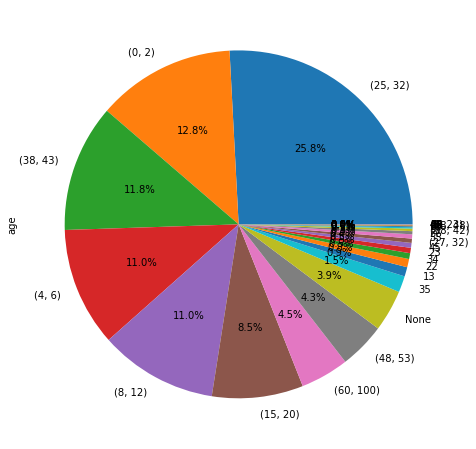

In [6]:
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

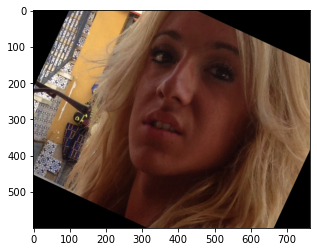

In [7]:
path = "data/faces/"+total_data.user_id.loc[0]+"/coarse_tilt_aligned_face."+str(total_data.face_id.loc[0])+"."+total_data.original_image.loc[0]
img = load_img(path)
plt.imshow(img)
plt.show()

### 2. preprocess data

In [8]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
img_path = []
for row in total_data.iterrows():
    path = "data/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [9]:
df.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,data/faces/30601258@N03/coarse_tilt_aligned_fa...
1,"(25, 32)",m,301,105,640,641,data/faces/30601258@N03/coarse_tilt_aligned_fa...
2,"(25, 32)",f,2395,876,771,771,data/faces/30601258@N03/coarse_tilt_aligned_fa...
3,"(25, 32)",m,752,1255,484,485,data/faces/30601258@N03/coarse_tilt_aligned_fa...
4,"(25, 32)",m,175,80,769,768,data/faces/30601258@N03/coarse_tilt_aligned_fa...


In [10]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), 
               ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'),
               ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), 
               ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), 
               ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), 
               ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), 
               ('57', '60+'), ('58', '60+')]

In [11]:
age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

C:\Users\yusha\.conda\envs\tf\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [12]:
df = df.dropna()

In [13]:
X = df[['img_path']]
y = df[['age']]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(y)
Y_onehot = np_utils.to_categorical(Y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, Y_onehot, test_size=0.3, random_state=42, shuffle=True)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12985, 1)
Test data shape (5566, 1)


C:\Users\yusha\.conda\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [15]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))


Train images shape (12985, 227, 227, 3)
Test images shape (5566, 227, 227, 3)


In [18]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np

In [20]:
np.random.seed(1000)
num_classes = 8

baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(227, 227, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(lr=1e-3, decay= 1e-3 / 20)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

C:\Users\yusha\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
history = model.fit(train_images, y_train, batch_size=32, epochs=18, validation_data=(test_images, y_test))

Epoch 1/18
406/406 [==============================] - 62s 126ms/step - loss: 2.1713 - accuracy: 0.3209 - val_loss: 1.6159 - val_accuracy: 0.4102
Epoch 2/18
406/406 [==============================] - 44s 109ms/step - loss: 1.6777 - accuracy: 0.3845 - val_loss: 1.5435 - val_accuracy: 0.4136
Epoch 3/18
406/406 [==============================] - 44s 109ms/step - loss: 1.6155 - accuracy: 0.4045 - val_loss: 1.5198 - val_accuracy: 0.4184
Epoch 4/18
406/406 [==============================] - 44s 109ms/step - loss: 1.5825 - accuracy: 0.4114 - val_loss: 1.4940 - val_accuracy: 0.4353
Epoch 5/18
406/406 [==============================] - 44s 109ms/step - loss: 1.5381 - accuracy: 0.4249 - val_loss: 1.4722 - val_accuracy: 0.4400
Epoch 6/18
406/406 [==============================] - 44s 109ms/step - loss: 1.5077 - accuracy: 0.4266 - val_loss: 1.4422 - val_accuracy: 0.4441
Epoch 7/18
406/406 [==============================] - 44s 109ms/step - loss: 1.4824 - accuracy: 0.4392 - val_loss: 1.4196 - val_ac

KeyboardInterrupt: 

In [23]:
model.save('age_model_vgg_pre-trained.h5')

In [25]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

174/174 - 13s - loss: 1.3565 - accuracy: 0.4871
0.48706433176994324


In [26]:
print("Saved model to disk")
print(history.history.keys())

Saved model to disk


NameError: name 'history' is not defined

In [27]:
plt.show()

plt.plot(history.history['accuracy'])

plt.plot(history.history['loss'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'validation', 'val_accuracy'], loc='upper left')

plt.show()

NameError: name 'history' is not defined

In [28]:
import random 
sample_num = random.randint(0, test_images.shape[0]) 
test_sample = test_images[sample_num]

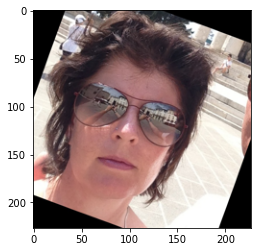

In [29]:
plt.imshow(test_sample)
plt.show()

In [32]:
predictions = model.predict(test_sample.reshape((-1,227,227,3)))
print('predicted probability: ' + str(predictions))

predicted probability: [[3.7038124e-05 1.4260194e-01 3.9868090e-01 2.6831037e-01 2.2730236e-03
  5.8435056e-02 3.4505535e-02 9.5156141e-02]]


In [33]:
encoder.inverse_transform(predicted_label)

NameError: name 'predicted_label' is not defined